## For Wednesday, November 13, please list what you proposed to have completed by the middle of Week 7, and summarize what you have accomplished.  You can be as detailed as you like.  This counts towards your preliminary report score.

## Proposed to be done by the end of the week:

* Start working on frequency analysis of studio recorded music clips.
* Start working on time analysis for both live music and studio recorded music.
* Decide a way to use polynomial function to denoise live music while maintaining natural form

### From Before(for code integrity):

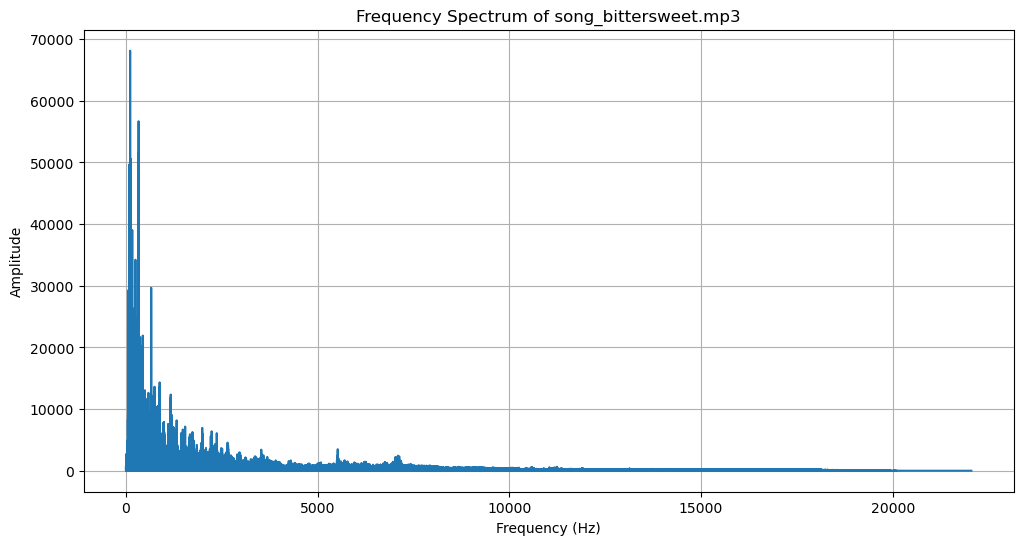

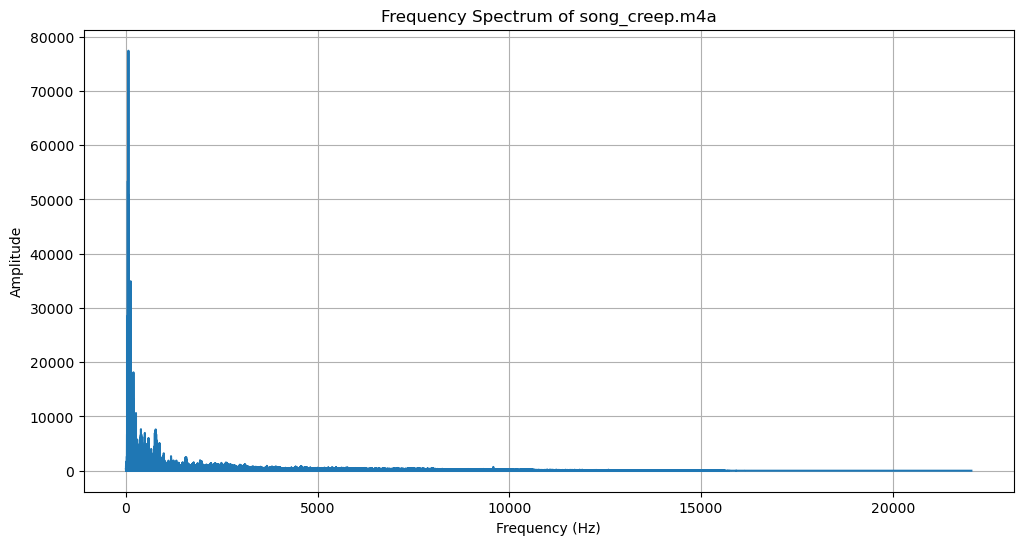

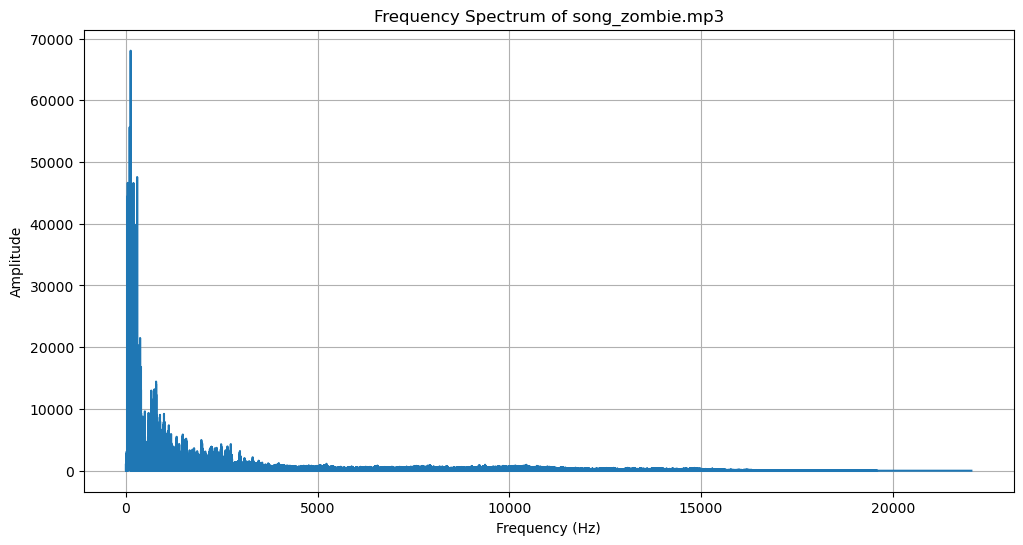

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import librosa

song_files = glob.glob('song_*.*')
for song_file in song_files:

    data, sample_rate = librosa.load(song_file, sr=None, mono=True)
    N = len(data)

    yf = np.fft.fft(data)
    xf = np.fft.fftfreq(N, 1 / sample_rate)
    idxs = np.where(xf >= 0)
    xf = xf[idxs]
    yf = np.abs(yf[idxs])

    plt.figure(figsize=(12, 6))
    plt.plot(xf, yf)
    plt.title(f'Frequency Spectrum of {os.path.basename(song_file)}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()


## New Progress

### Import libraries and create studio to live recording pairs

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
from scipy.signal import correlate
import os

import warnings
warnings.filterwarnings('ignore')
songs = [
    {'live': 'song_zombie.mp3', 'studio': 'zombie.wav'},
    {'live': 'song_creep.mp3', 'studio': 'creep.wav'},
    {'live': 'song_bittersweet.mp3', 'studio': 'bittersweet.wav'}
]

### Process each song by:
* Normalize the audio signals
* Time alignment using cross-correlation
* Align the live recording
* Truncate to the same length
* Compute STFT
* Compute magnitude and phase
* Spectral subtraction
* Reconstruct the denoised signal
* Normalize denoised audio


Processing 'zombie'...
  Performing time alignment...
  Computing STFT...
  Applying spectral subtraction...
  Denoised audio saved to 'denoised_zombie.wav'.
  Plotting the results...


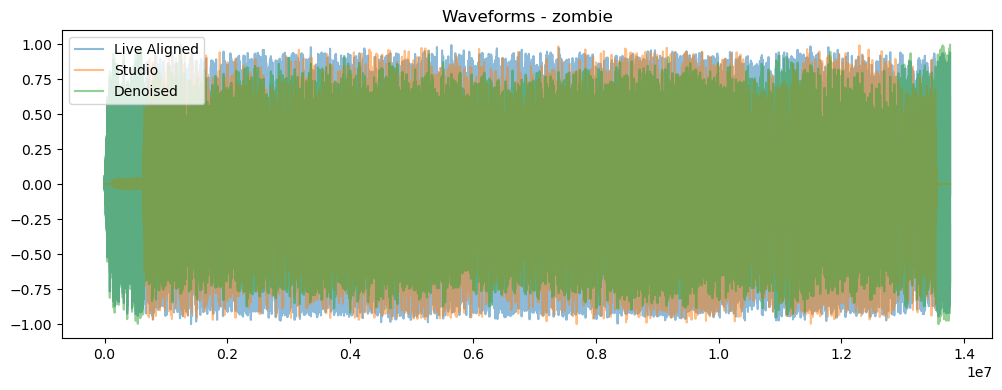

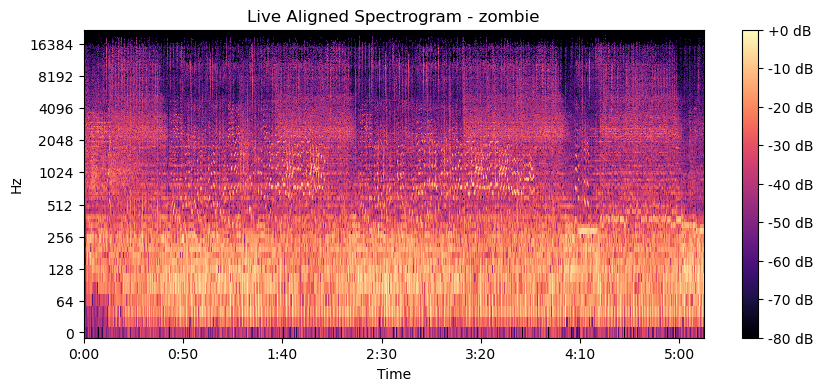

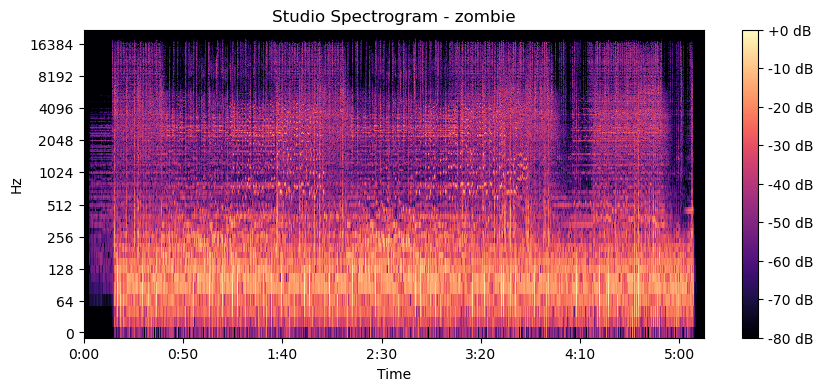

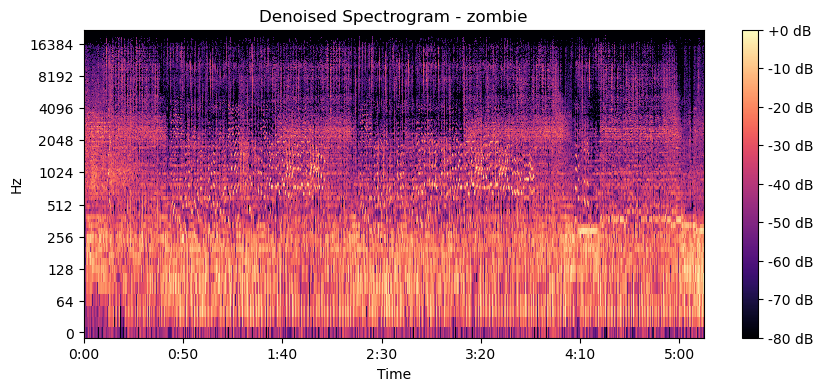

Finished processing 'zombie'.


Processing 'creep'...


FileNotFoundError: [Errno 2] No such file or directory: 'song_creep.mp3'

In [9]:


for song in songs:
    live_file = song['live']
    studio_file = song['studio']
    song_name = os.path.splitext(os.path.basename(studio_file))[0]
    
    print(f"\nProcessing '{song_name}'...")
    data_live, sr_live = librosa.load(live_file, sr=None, mono=True)
    data_studio, sr_studio = librosa.load(studio_file, sr=None, mono=True)
    if sr_live != sr_studio:
        data_live = librosa.resample(data_live, sr_live, sr_studio)
        sr_live = sr_studio
    data_live = data_live / np.max(np.abs(data_live))
    data_studio = data_studio / np.max(np.abs(data_studio))
    print("  Performing time alignment...")
    correlation = correlate(data_live, data_studio, mode='full')
    lag = np.argmax(correlation) - len(data_studio) + 1
    if lag > 0:
        data_live_aligned = data_live[lag:]
    else:
        data_live_aligned = np.pad(data_live, (abs(lag), 0), 'constant')

   
    min_length = min(len(data_live_aligned), len(data_studio))
    data_live_aligned = data_live_aligned[:min_length]
    data_studio = data_studio[:min_length]


    print("  Computing STFT...")
    D_live = librosa.stft(data_live_aligned, n_fft=2048, hop_length=512)
    D_studio = librosa.stft(data_studio, n_fft=2048, hop_length=512)

    mag_live, phase_live = librosa.magphase(D_live)
    mag_studio, _ = librosa.magphase(D_studio)

    print("  Applying spectral subtraction...")
    mag_diff = mag_live - mag_studio
    mag_diff = np.maximum(mag_diff, 0)

    
    D_denoised = mag_diff * phase_live
    data_live_denoised = librosa.istft(D_denoised, hop_length=512)
    data_live_denoised = data_live_denoised / np.max(np.abs(data_live_denoised))
    output_file = f"denoised_{song_name}.wav"
    sf.write(output_file, data_live_denoised, sr_studio)
    print(f"  Denoised audio saved to '{output_file}'.")

    # Plotting the results
    print("  Plotting the results...")
    plt.figure(figsize=(12, 4))
    plt.title(f"Waveforms - {song_name}")
    plt.plot(data_live_aligned, label='Live Aligned', alpha=0.5)
    plt.plot(data_studio, label='Studio', alpha=0.5)
    plt.plot(data_live_denoised, label='Denoised', alpha=0.5)
    plt.legend()
    plt.show()

    # Plot spectrograms
    def plot_spectrogram(data, sr, title):
        D = librosa.amplitude_to_db(np.abs(librosa.stft(data, n_fft=2048, hop_length=512)), ref=np.max)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(D, sr=sr, hop_length=512, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.show()

    plot_spectrogram(data_live_aligned, sr_studio, f'Live Aligned Spectrogram - {song_name}')
    plot_spectrogram(data_studio, sr_studio, f'Studio Spectrogram - {song_name}')
    plot_spectrogram(data_live_denoised, sr_studio, f'Denoised Spectrogram - {song_name}')

    print(f"Finished processing '{song_name}'.\n")


### In the above charts it shows we achieved successful time and frequency alignment with live and studio recordings, however the normalization functions made denoise audio seem a little unnatural which would be improved in new updates.

## Next Steps
* find alternative to normalizing functions
* find polynomial function for each song to denoise the live music
* find better way to improve the alignment between studio and live music

### However, the product we got from the end does not sound very good, so instead of Cross-correlation, we use a Dynamic time warping alignment

In [ ]:
import librosa.sequence

for song in songs:
    live_file = song['live']
    studio_file = song['studio']
    song_name = os.path.splitext(os.path.basename(studio_file))[0]
    
    print(f"\nProcessing '{song_name}'...")
    data_live, sr_live = librosa.load(live_file, sr=None, mono=True)
    data_studio, sr_studio = librosa.load(studio_file, sr=None, mono=True)
    if sr_live != sr_studio:
        data_live = librosa.resample(data_live, sr_live, sr_studio)
        sr_live = sr_studio
    data_live = data_live / np.max(np.abs(data_live))
    data_studio = data_studio / np.max(np.abs(data_studio))
    
    
    
    print("  Performing time alignment...")
    correlation = correlate(data_live, data_studio, mode='full')
    lag = np.argmax(correlation) - len(data_studio) + 1
    if lag > 0:
        data_live_aligned = data_live[lag:]
    else:
        data_live_aligned = np.pad(data_live, (abs(lag), 0), 'constant')

   
    min_length = min(len(data_live_aligned), len(data_studio))
    data_live_aligned = data_live_aligned[:min_length]
    data_studio = data_studio[:min_length]


    print("  Computing STFT...")
    D_live = librosa.stft(data_live_aligned, n_fft=2048, hop_length=512)
    D_studio = librosa.stft(data_studio, n_fft=2048, hop_length=512)

    mag_live, phase_live = librosa.magphase(D_live)
    mag_studio, _ = librosa.magphase(D_studio)

    print("  Applying spectral subtraction...")
    mag_diff = mag_live - mag_studio
    mag_diff = np.maximum(mag_diff, 0)

    
    D_denoised = mag_diff * phase_live
    data_live_denoised = librosa.istft(D_denoised, hop_length=512)
    data_live_denoised = data_live_denoised / np.max(np.abs(data_live_denoised))
    output_file = f"denoised_{song_name}.wav"
    sf.write(output_file, data_live_denoised, sr_studio)
    print(f"  Denoised audio saved to '{output_file}'.")

    # Plotting the results
    print("  Plotting the results...")
    plt.figure(figsize=(12, 4))
    plt.title(f"Waveforms - {song_name}")
    plt.plot(data_live_aligned, label='Live Aligned', alpha=0.5)
    plt.plot(data_studio, label='Studio', alpha=0.5)
    plt.plot(data_live_denoised, label='Denoised', alpha=0.5)
    plt.legend()
    plt.show()

    # Plot spectrograms
    def plot_spectrogram(data, sr, title):
        D = librosa.amplitude_to_db(np.abs(librosa.stft(data, n_fft=2048, hop_length=512)), ref=np.max)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(D, sr=sr, hop_length=512, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.show()

    plot_spectrogram(data_live_aligned, sr_studio, f'Live Aligned Spectrogram - {song_name}')
    plot_spectrogram(data_studio, sr_studio, f'Studio Spectrogram - {song_name}')
    plot_spectrogram(data_live_denoised, sr_studio, f'Denoised Spectrogram - {song_name}')

    print(f"Finished processing '{song_name}'.\n")


In [ ]:
import librosa.sequence

# Extract features (e.g., chroma features)
chroma_live = librosa.feature.chroma_cqt(y=data_live, sr=sr_live)
chroma_studio = librosa.feature.chroma_cqt(y=data_studio, sr=sr_studio)

# Compute the alignment path
D, wp = librosa.sequence.dtw(X=chroma_studio, Y=chroma_live, metric='cosine')

# Map the live recording to the studio recording
indices_live = wp[:, 1]
indices_studio = wp[:, 0]

# Interpolate to align the live recording
data_live_aligned_2 = np.interp(np.arange(len(data_studio)), indices_live, data_live)


### here we compare the result of correlation withDFW 


Processing 'zombie'...
  Performing time alignment using cross-correlation...
  Performing time alignment using DTW...
  Comparing alignment accuracy...
    Cross-Correlation alignment error: 1079.66
    DTW alignment error: 532.53
    DTW provides better alignment.
  Computing STFT using DTW aligned audio...
  Applying spectral subtraction...
  Denoised audio saved to 'denoised_zombie.wav'.
  Plotting the results...


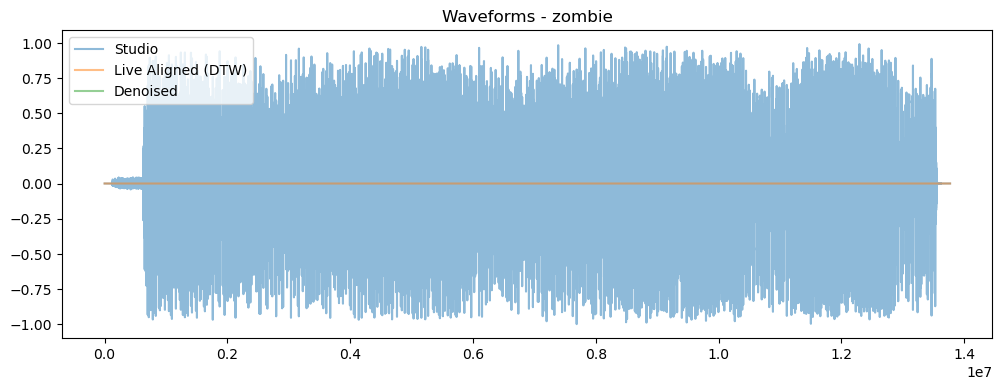

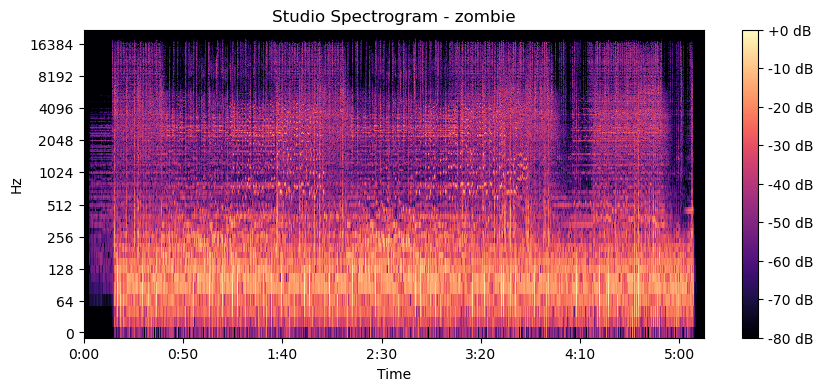

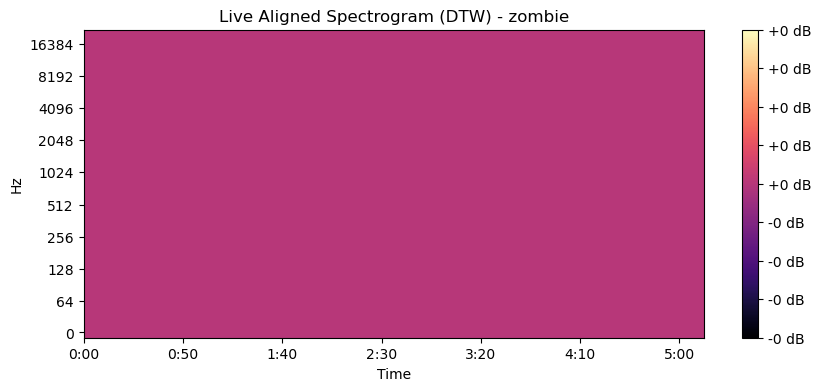

ParameterError: Audio buffer is not finite everywhere

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
from scipy.signal import correlate
import os
import librosa.display
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# List of songs to process
songs = [
    {'live': 'song_zombie.mp3', 'studio': 'zombie.wav'},
    {'live': 'song_creep.mp3', 'studio': 'creep.wav'},
    {'live': 'song_bittersweet.mp3', 'studio': 'bittersweet.wav'}
]

for song in songs:
    live_file = song['live']
    studio_file = song['studio']
    song_name = os.path.splitext(os.path.basename(studio_file))[0]
    
    print(f"\nProcessing '{song_name}'...")
    
    # Load live and studio recordings
    data_live, sr_live = librosa.load(live_file, sr=None, mono=True)
    data_studio, sr_studio = librosa.load(studio_file, sr=None, mono=True)
    
    # Ensure sampling rates match
    if sr_live != sr_studio:
        data_live = librosa.resample(data_live, sr_live, sr_studio)
        sr_live = sr_studio
    
    # Normalize the audio signals
    data_live = data_live / np.max(np.abs(data_live))
    data_studio = data_studio / np.max(np.abs(data_studio))
    
    # Truncate longer signal to match the shorter one
    min_length = min(len(data_live), len(data_studio))
    data_live = data_live[:min_length]
    data_studio = data_studio[:min_length]
    
    # Time alignment using cross-correlation
    print("  Performing time alignment using cross-correlation...")
    correlation = correlate(data_live, data_studio, mode='full')
    lag = np.argmax(correlation) - len(data_studio) + 1
    
    if lag > 0:
        data_live_cc = data_live[lag:]
        if len(data_live_cc) < len(data_studio):
            data_live_cc = np.pad(data_live_cc, (0, len(data_studio) - len(data_live_cc)), 'constant')
    else:
        data_live_cc = np.pad(data_live, (abs(lag), 0), 'constant')
    data_live_cc = data_live_cc[:len(data_studio)]
    
    # Time alignment using DTW
    print("  Performing time alignment using DTW...")
    # Extract MFCC features for DTW
    mfcc_live = librosa.feature.mfcc(y=data_live, sr=sr_live, n_mfcc=20)
    mfcc_studio = librosa.feature.mfcc(y=data_studio, sr=sr_studio, n_mfcc=20)
    
    # Compute the alignment path using DTW
    D, wp = librosa.sequence.dtw(X=mfcc_studio.T, Y=mfcc_live.T, metric='euclidean')
    
    # Map live audio to studio timeline
    idx_studio = wp[:, 0]
    idx_live = wp[:, 1]
    
    # Remove duplicate indices for interpolation
    sorted_idx_live, unique_indices = np.unique(idx_live, return_index=True)
    sorted_idx_studio = idx_studio[unique_indices]
    
    # Interpolate aligned live audio
    data_live_dtw = np.interp(
        np.arange(len(data_studio)),
        sorted_idx_live,
        data_live[sorted_idx_live]
    )
    
    # Ensure data_live_dtw and data_studio have the same length
    if len(data_live_dtw) < len(data_studio):
        data_live_dtw = np.pad(data_live_dtw, (0, len(data_studio) - len(data_live_dtw)), 'constant')
    elif len(data_live_dtw) > len(data_studio):
        data_live_dtw = data_live_dtw[:len(data_studio)]
    
    # Compare Alignment Accuracy
    print("  Comparing alignment accuracy...")
    # Compute the difference between aligned live and studio recordings
    diff_cc = np.linalg.norm(data_live_cc - data_studio)
    diff_dtw = np.linalg.norm(data_live_dtw - data_studio)
    
    print(f"    Cross-Correlation alignment error: {diff_cc:.2f}")
    print(f"    DTW alignment error: {diff_dtw:.2f}")
    
    # Decide which alignment to use based on lower error
    if diff_dtw < diff_cc:
        print("    DTW provides better alignment.")
        data_live_aligned = data_live_dtw
        alignment_method = 'DTW'
    else:
        print("    Cross-Correlation provides better alignment.")
        data_live_aligned = data_live_cc
        alignment_method = 'Cross-Correlation'
    
    # Proceed with denoising using the chosen alignment
    # Compute STFT
    print(f"  Computing STFT using {alignment_method} aligned audio...")
    D_live = librosa.stft(data_live_aligned, n_fft=2048, hop_length=512)
    D_studio = librosa.stft(data_studio, n_fft=2048, hop_length=512)
    
    # Compute magnitude and phase
    mag_live, phase_live = librosa.magphase(D_live)
    mag_studio, _ = librosa.magphase(D_studio)
    
    # Spectral subtraction
    print("  Applying spectral subtraction...")
    mag_diff = mag_live - mag_studio
    mag_diff = np.maximum(mag_diff, 0)
    
    # Reconstruct the denoised signal
    D_denoised = mag_diff * phase_live
    data_live_denoised = librosa.istft(D_denoised, hop_length=512)
    
    # Normalize the denoised audio
    data_live_denoised = data_live_denoised / np.max(np.abs(data_live_denoised))
    
    # Save the denoised audio
    output_file = f"denoised_{song_name}.wav"
    sf.write(output_file, data_live_denoised, sr_studio)
    print(f"  Denoised audio saved to '{output_file}'.")
    
    # Plotting the results
    print("  Plotting the results...")
    plt.figure(figsize=(12, 4))
    plt.title(f"Waveforms - {song_name}")
    plt.plot(data_studio, label='Studio', alpha=0.5)
    plt.plot(data_live_aligned, label=f'Live Aligned ({alignment_method})', alpha=0.5)
    plt.plot(data_live_denoised, label='Denoised', alpha=0.5)
    plt.legend()
    plt.show()
    
    # Plot spectrograms
    def plot_spectrogram(data, sr, title):
        D = librosa.amplitude_to_db(np.abs(librosa.stft(data, n_fft=2048, hop_length=512)), ref=np.max)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(D, sr=sr, hop_length=512, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.show()
    
    plot_spectrogram(data_studio, sr_studio, f'Studio Spectrogram - {song_name}')
    plot_spectrogram(data_live_aligned, sr_studio, f'Live Aligned Spectrogram ({alignment_method}) - {song_name}')
    plot_spectrogram(data_live_denoised, sr_studio, f'Denoised Spectrogram - {song_name}')
    
    print(f"Finished processing '{song_name}'.\n")


In [10]:
# Only process 'zombie'
song = {'live': 'song_creep.m4a', 'studio': 'creep.wav'}



Processing 'zombie'...
  Performing time alignment using cross-correlation...
  Performing time alignment using DTW...
  Comparing alignment accuracy...
    Cross-Correlation alignment error: 1079.66
    DTW alignment error: 532.53
    DTW provides better alignment.
  Computing STFT using DTW aligned audio...
  Applying spectral subtraction with scaling factor...
  Checking for non-finite values in denoised audio...
  Denoised audio saved to 'denoised_zombie.wav'.
  Plotting the results...


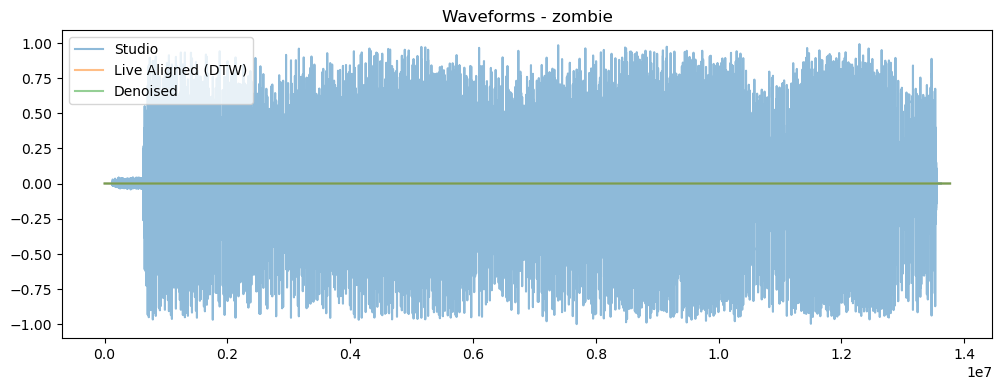

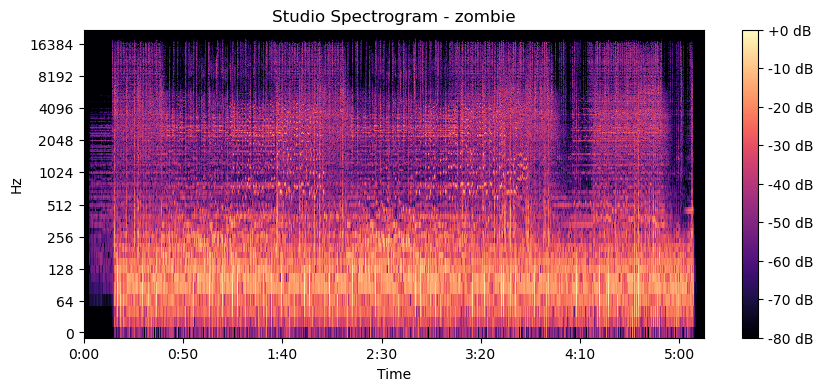

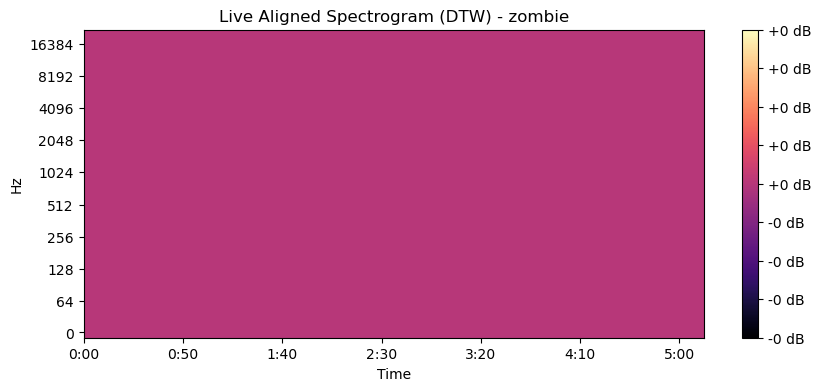

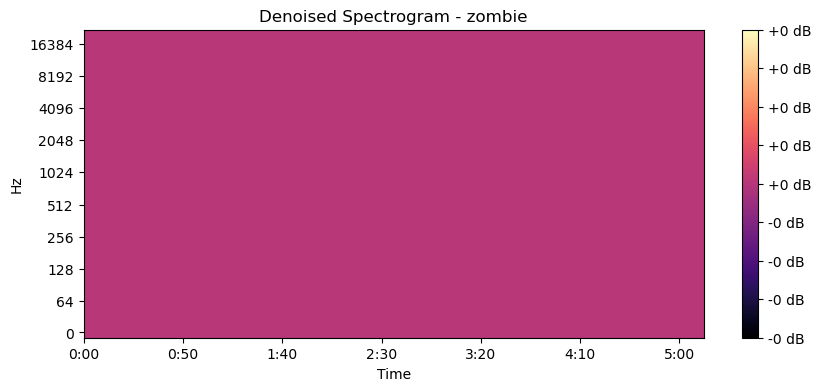

Finished processing 'zombie'.



In [11]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
from scipy.signal import correlate
import librosa.display
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Process only one song
song = {'live': 'song_zombie.mp3', 'studio': 'zombie.wav'}
live_file = song['live']
studio_file = song['studio']
song_name = os.path.splitext(os.path.basename(studio_file))[0]

print(f"\nProcessing '{song_name}'...")

# Load live and studio recordings
data_live, sr_live = librosa.load(live_file, sr=None, mono=True)
data_studio, sr_studio = librosa.load(studio_file, sr=None, mono=True)

# Ensure sampling rates match
if sr_live != sr_studio:
    data_live = librosa.resample(data_live, sr_live, sr_studio)
    sr_live = sr_studio

# Normalize the audio signals
data_live = data_live / np.max(np.abs(data_live))
data_studio = data_studio / np.max(np.abs(data_studio))

# Truncate longer signal to match the shorter one
min_length = min(len(data_live), len(data_studio))
data_live = data_live[:min_length]
data_studio = data_studio[:min_length]

# Time alignment using cross-correlation
print("  Performing time alignment using cross-correlation...")
correlation = correlate(data_live, data_studio, mode='full')
lag = np.argmax(correlation) - len(data_studio) + 1

if lag > 0:
    data_live_cc = data_live[lag:]
    if len(data_live_cc) < len(data_studio):
        data_live_cc = np.pad(data_live_cc, (0, len(data_studio) - len(data_live_cc)), 'constant')
else:
    data_live_cc = np.pad(data_live, (abs(lag), 0), 'constant')
data_live_cc = data_live_cc[:len(data_studio)]

# Time alignment using DTW
print("  Performing time alignment using DTW...")
# Extract MFCC features for DTW
mfcc_live = librosa.feature.mfcc(y=data_live, sr=sr_live, n_mfcc=20)
mfcc_studio = librosa.feature.mfcc(y=data_studio, sr=sr_studio, n_mfcc=20)

# Compute the alignment path using DTW
D, wp = librosa.sequence.dtw(X=mfcc_studio.T, Y=mfcc_live.T, metric='euclidean')

# Map live audio to studio timeline
idx_studio = wp[:, 0]
idx_live = wp[:, 1]

# Remove duplicate indices for interpolation
sorted_idx_live, unique_indices = np.unique(idx_live, return_index=True)
sorted_idx_studio = idx_studio[unique_indices]

# Interpolate aligned live audio
data_live_dtw = np.interp(
    np.arange(len(data_studio)),
    sorted_idx_live,
    data_live[sorted_idx_live]
)

# Ensure data_live_dtw and data_studio have the same length
if len(data_live_dtw) < len(data_studio):
    data_live_dtw = np.pad(data_live_dtw, (0, len(data_studio) - len(data_live_dtw)), 'constant')
elif len(data_live_dtw) > len(data_studio):
    data_live_dtw = data_live_dtw[:len(data_studio)]

# Compare Alignment Accuracy
print("  Comparing alignment accuracy...")
# Compute the difference between aligned live and studio recordings
diff_cc = np.linalg.norm(data_live_cc - data_studio)
diff_dtw = np.linalg.norm(data_live_dtw - data_studio)

print(f"    Cross-Correlation alignment error: {diff_cc:.2f}")
print(f"    DTW alignment error: {diff_dtw:.2f}")

# Decide which alignment to use based on lower error
if diff_dtw < diff_cc:
    print("    DTW provides better alignment.")
    data_live_aligned = data_live_dtw
    alignment_method = 'DTW'
else:
    print("    Cross-Correlation provides better alignment.")
    data_live_aligned = data_live_cc
    alignment_method = 'Cross-Correlation'

# Proceed with denoising using the chosen alignment
# Compute STFT
print(f"  Computing STFT using {alignment_method} aligned audio...")
D_live = librosa.stft(data_live_aligned, n_fft=2048, hop_length=512)
D_studio = librosa.stft(data_studio, n_fft=2048, hop_length=512)

# Compute magnitude and phase
mag_live, phase_live = librosa.magphase(D_live)
mag_studio, _ = librosa.magphase(D_studio)

# Spectral subtraction with scaling factor
print("  Applying spectral subtraction with scaling factor...")
scaling_factor = 0.5  # Adjust between 0 and 1 to prevent over-subtraction
mag_diff = mag_live - scaling_factor * mag_studio
mag_diff = np.maximum(mag_diff, 0)

# Reconstruct the denoised signal
D_denoised = mag_diff * phase_live
data_live_denoised = librosa.istft(D_denoised, hop_length=512)

# Normalize the denoised audio
if np.max(np.abs(data_live_denoised)) > 0:
    data_live_denoised = data_live_denoised / np.max(np.abs(data_live_denoised))
else:
    print("  Warning: Denoised audio is silent.")
    data_live_denoised = np.zeros_like(data_live_denoised)

# Check for non-finite values
print("  Checking for non-finite values in denoised audio...")
if not np.isfinite(data_live_denoised).all():
    print("  Non-finite values found in denoised audio. Replacing with zeros.")
    data_live_denoised = np.nan_to_num(data_live_denoised)

# Save the denoised audio
output_file = f"denoised_{song_name}.wav"
sf.write(output_file, data_live_denoised, sr_studio)
print(f"  Denoised audio saved to '{output_file}'.")

# Plotting the results
print("  Plotting the results...")
plt.figure(figsize=(12, 4))
plt.title(f"Waveforms - {song_name}")
plt.plot(data_studio, label='Studio', alpha=0.5)
plt.plot(data_live_aligned, label=f'Live Aligned ({alignment_method})', alpha=0.5)
plt.plot(data_live_denoised, label='Denoised', alpha=0.5)
plt.legend()
plt.show()

# Plot spectrograms
def plot_spectrogram(data, sr, title):
    if not np.isfinite(data).all():
        print(f"  Cannot plot spectrogram for '{title}' due to non-finite values.")
        return
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data, n_fft=2048, hop_length=512)), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, hop_length=512, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

plot_spectrogram(data_studio, sr_studio, f'Studio Spectrogram - {song_name}')
plot_spectrogram(data_live_aligned, sr_studio, f'Live Aligned Spectrogram ({alignment_method}) - {song_name}')
plot_spectrogram(data_live_denoised, sr_studio, f'Denoised Spectrogram - {song_name}')

print(f"Finished processing '{song_name}'.\n")


In [5]:
# Install pyloudnorm if not already installed

import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
from scipy.signal import correlate
import librosa.display
import pyloudnorm as pyln
import warnings
import os



# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Process only one song
song = {'live': 'song_zombie.mp3', 'studio': 'zombie.wav'}
live_file = song['live']
studio_file = song['studio']
song_name = os.path.splitext(os.path.basename(studio_file))[0]

print(f"\nProcessing '{song_name}'...")

# Load live and studio recordings
data_live, sr_live = librosa.load(live_file, sr=None, mono=True)
data_studio, sr_studio = librosa.load(studio_file, sr=None, mono=True)

# Ensure sampling rates match
if sr_live != sr_studio:
    data_live = librosa.resample(data_live, sr_live, sr_studio)
    sr_live = sr_studio

# Truncate longer signal to match the shorter one
min_length = min(len(data_live), len(data_studio))
data_live = data_live[:min_length]
data_studio = data_studio[:min_length]

# Time alignment using DTW (since DTW provided better alignment previously)
print("  Performing time alignment using DTW...")
# Extract MFCC features for DTW
mfcc_live = librosa.feature.mfcc(y=data_live, sr=sr_live, n_mfcc=20)
mfcc_studio = librosa.feature.mfcc(y=data_studio, sr=sr_studio, n_mfcc=20)

# Compute the alignment path using DTW
D, wp = librosa.sequence.dtw(X=mfcc_studio.T, Y=mfcc_live.T, metric='euclidean')

# Map live audio to studio timeline
idx_studio = wp[:, 0]
idx_live = wp[:, 1]

# Remove duplicate indices for interpolation
sorted_idx_live, unique_indices = np.unique(idx_live, return_index=True)
sorted_idx_studio = idx_studio[unique_indices]

# Interpolate aligned live audio
data_live_aligned = np.interp(
    np.arange(len(data_studio)),
    sorted_idx_live,
    data_live[sorted_idx_live]
)

# Ensure data_live_aligned and data_studio have the same length
if len(data_live_aligned) < len(data_studio):
    data_live_aligned = np.pad(data_live_aligned, (0, len(data_studio) - len(data_live_aligned)), 'constant')
elif len(data_live_aligned) > len(data_studio):
    data_live_aligned = data_live_aligned[:len(data_studio)]

# Normalize loudness of both signals
print("  Normalizing loudness of recordings...")
meter = pyln.Meter(sr_live)
loudness_live = meter.integrated_loudness(data_live_aligned)
loudness_studio = meter.integrated_loudness(data_studio)
target_loudness = -23.0  # LUFS

data_live_aligned = pyln.normalize.loudness(data_live_aligned, loudness_live, target_loudness)
data_studio = pyln.normalize.loudness(data_studio, loudness_studio, target_loudness)

# Compute STFT
print(f"  Computing STFT using DTW aligned audio...")
D_live = librosa.stft(data_live_aligned, n_fft=2048, hop_length=512)
D_studio = librosa.stft(data_studio, n_fft=2048, hop_length=512)

# Compute magnitude and phase
mag_live, phase_live = librosa.magphase(D_live)
mag_studio, _ = librosa.magphase(D_studio)

# Normalize magnitude spectra
mag_live_norm = mag_live / np.max(mag_live)
mag_studio_norm = mag_studio / np.max(mag_studio)

# Apply scaling factor to studio magnitude
scaling_factor = 0.1  # Try a lower scaling factor
mag_studio_scaled = scaling_factor * mag_studio_norm

# Perform spectral subtraction
print("  Applying spectral subtraction with scaling factor...")
mag_diff = mag_live_norm - mag_studio_scaled
mag_diff = np.maximum(mag_diff, 0)

# Reconstruct the denoised signal
mag_diff = mag_diff * np.max(mag_live)  # Scale back to original magnitude level
D_denoised = mag_diff * phase_live
data_live_denoised = librosa.istft(D_denoised, hop_length=512)

# Normalize the denoised audio
if np.max(np.abs(data_live_denoised)) > 0:
    data_live_denoised = data_live_denoised / np.max(np.abs(data_live_denoised))
else:
    print("  Warning: Denoised audio is silent.")
    data_live_denoised = np.zeros_like(data_live_denoised)

# Check for non-finite values
print("  Checking for non-finite values in denoised audio...")
if not np.isfinite(data_live_denoised).all():
    print("  Non-finite values found in denoised audio. Replacing with zeros.")
    data_live_denoised = np.nan_to_num(data_live_denoised)

# Save the denoised audio
output_file = f"denoised_{song_name}.wav"
sf.write(output_file, data_live_denoised, sr_studio)
print(f"  Denoised audio saved to '{output_file}'.")

# Plotting the results
print("  Plotting the results...")
plt.figure(figsize=(12, 4))
plt.title(f"Waveforms - {song_name}")
plt.plot(data_studio, label='Studio', alpha=0.5)
plt.plot(data_live_aligned, label='Live Aligned (DTW)', alpha=0.5)
plt.plot(data_live_denoised, label='Denoised', alpha=0.5)
plt.legend()
plt.show()

# Plot spectrograms
def plot_spectrogram(data, sr, title):
    if not np.isfinite(data).all():
        print(f"  Cannot plot spectrogram for '{title}' due to non-finite values.")
        return
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data, n_fft=2048, hop_length=512)), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, hop_length=512, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

plot_spectrogram(data_studio, sr_studio, f'Studio Spectrogram - {song_name}')
plot_spectrogram(data_live_aligned, sr_studio, f'Live Aligned Spectrogram (DTW) - {song_name}')
plot_spectrogram(data_live_denoised, sr_studio, f'Denoised Spectrogram - {song_name}')

print(f"Finished processing '{song_name}'.\n")



Processing 'zombie'...
  Performing time alignment using DTW...
  Normalizing loudness of recordings...
  Computing STFT using DTW aligned audio...


ParameterError: Audio buffer is not finite everywhere